In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score
import seaborn as sns
import shap
import pandas as pd

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Import Datasets

In [2]:
path = "Dataset"
pitstops = pd.read_csv(f"{path}/pit_stops.csv")
drivers = pd.read_csv(f"{path}/drivers.csv")
races = pd.read_csv(f"{path}/races.csv")
results = pd.read_csv(f"{path}/results.csv")
qualifying = pd.read_csv(f"{path}/qualifying.csv")
circuits = pd.read_csv(f"{path}/circuits.csv")


### Prepare the Data

Filtering races where raceId is 841 or more (races after 2011, because pitstop information exists only after 2011), and statusId is either 1 or between 11 and 19 ( driver successfully finishes the race )

In [3]:
results = results.query("raceId >= 841 and ( statusId == 1 or (statusId >= 11 and statusId <= 19))")

Count the total number of pitstops for each race-driver pair

In [4]:
pitstops_count = pitstops.groupby(['raceId' , 'driverId']).count()['stop']

Combining the number of pitstops with the table stores race results. Marking the pit strategy as 0 or 1, indicating unsuccessful or successful strategy. 

- successful(1)   : if the driver finishes at the same position or higher than their starting position (grid)
- unsuccessful(0) : if the driver finishes at a worse position than their starting position

In [5]:
results = results.merge(pitstops_count, how="left", on=['raceId' , 'driverId'])
results['pitstrategy'] = np.where(results['positionOrder'] <= results['grid'], 1, 0) 
results.dropna(subset=['stop'], inplace=True)
results  = results.query('grid <= 22 and grid>0')


Adding the q1 , q2 , q3 lap times for race-driver pair

In [6]:
df = results.drop(['number', 'resultId', 'points', 'laps', 'time', 'milliseconds', 'fastestLapTime', 'fastestLap', 'fastestLapSpeed', 'statusId', 'time', 'position', 'positionText', 'resultId'], axis=1)
df = df.merge(races[['raceId', 'circuitId', 'year']], how='left', on=['raceId'])
df = df.merge(qualifying[['raceId' , 'driverId', 'q1','q2','q3']], on=['raceId' , 'driverId'], how="left")
df['rank'] = df['rank'].astype('int64')

Filling non-existing qualification lap times

In [7]:
for i in df.index.values:
    q3 = df.loc[i, 'q3']
    if  ":" not in str(q3):
        df.loc[i, 'q3'] = df.loc[i - 1, 'q3']

    q2 = df.loc[i, 'q2']
    if ":" not in str(q2):
        df.loc[i, 'q2'] = df.loc[i - 1, 'q2']

    q1 = df.loc[i, 'q1']
    if ":" not in str(q1):
        df.loc[i, 'q1'] = df.loc[i - 1, 'q1']

Converting date-time to milliseconds

In [8]:
def convert_to_time(value):
    value = str(value)
    parts = value.split(':')
    parts1 = parts[1].split(".")

    minutes = int(parts[0])
    seconds = int(parts1[0])
    milliseconds = int(parts1[1])
    return 60*1000*minutes + 1000*seconds + milliseconds

for column in ['q3','q2','q1']:
    df[column] = df[column].apply(convert_to_time)

iterates over and normalizes the 'q1', 'q2', and 'q3' values by dividing each value by its respective minimum

In [9]:
raceIds = np.unique(df['raceId'])

for raceId in raceIds:
    filtered_acc_race = df[df['raceId'] == raceId]
    min_q1 = np.min(filtered_acc_race['q1'])
    min_q2 = np.min(filtered_acc_race['q2'])
    min_q3 = np.min(filtered_acc_race['q3'])
    for i in filtered_acc_race.index.values:
        df.loc[i, 'q1'] = df.loc[i, 'q1'] / min_q1
        df.loc[i, 'q2'] = df.loc[i, 'q2'] / min_q2
        df.loc[i, 'q3'] = df.loc[i, 'q3'] / min_q3

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.001031701369349' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.006005470329409' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1.0093141304217697' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.


Calculates the average finishing position for each driver up to each race

In [10]:
df['avg_finish'] = np.zeros(len(df))
for i in df.index.values:
    driverId , raceId = df.loc[i, 'driverId'] , df.loc[i, 'raceId']
    all_previous = results.query(f"driverId == {driverId} and  raceId < {raceId}")
    average_finish = 21
    if len(all_previous) != 0:
        average_finish = np.sum( all_previous['positionOrder'] ) / len(all_previous)
        df.loc[i, 'avg_finish'] = average_finish


## XGBoost with GridSearchCV 

 PitstopStrategy Class implemented for analyzing pitstop strategies for a specific circuit. Within this class, it splits the data into training, testing, and validation sets, performs parameter tuning using GridSearchCV to find the best parameters for the XGBoost classifier, trains the model with the best parameters, evaluates the model's performance using accuracy scores, classification reports, and confusion matrices, and displays the feature importances.

In [11]:
from xgboost import plot_importance

class PitstopStrategy:
    def __init__(self, df, circuitID):
        self.model = None 
        self.circuitId = circuitID
        df = df.query(f" (circuitId=={self.circuitId}) and pitstrategy==1 and stop <= 3")
        
        # prepare X, y 
        y = df[['stop']] - 1 
        X = df.drop(columns=['pitstrategy','positionOrder','stop', 'raceId']) 
        
        # train / test / val split 
        self.X_train, self.X_test = train_test_split(X, train_size=0.67, random_state=42)
        self.y_train, self.y_test = train_test_split(y, train_size=0.67, random_state=42)
        
        self.X_train , self.X_val = train_test_split(self.X_train, train_size=0.67, random_state=42)
        self.y_train , self.y_val = train_test_split(self.y_train, train_size=0.67, random_state=42)
        
    def report(self):
        
        grid_xgb_training_preds = self.model.predict(self.X_train)
        grid_xgb_test_preds = self.model.predict(self.X_test)

        accuracy_grid_xgb_train = accuracy_score(self.y_train,grid_xgb_training_preds)
        accuracy_grid_xgb_test = accuracy_score(self.y_test,grid_xgb_test_preds)
        
        print(f"    ---------------- TEST SCORES ----------------    \n")

        print(f"               Accuracy (TRAIN) : {accuracy_grid_xgb_train} \n               ACCURACY (TEST) : {accuracy_grid_xgb_test}")
        print('----------------------------------------------------------')
        print(classification_report(self.y_test,grid_xgb_test_preds))
        
    
    def feature_imp(self):
        plot_importance(self.model)
    
    def parameter_tuning(self,search_parameters):
        
        xgb = XGBClassifier(eval_metric='mlogloss')
        grid_xgb = GridSearchCV(xgb, search_parameters, scoring='accuracy', cv=None, n_jobs=1)
        grid_xgb.fit(self.X_train, self.y_train, verbose=2)
        
        best_xgb_parameters = grid_xgb.best_params_
        
        print('Grid Search found the following optimal parameters: ')
        for param_name in sorted(best_xgb_parameters.keys()):
            
            print('%s: %r' % (param_name, best_xgb_parameters[param_name]))
        print("\n\n")
        return best_xgb_parameters 
    
    def train_model_with_best_params(self, best_params):
        colsample_bytree = best_params['colsample_bytree']
        gamma = best_params['gamma']
        max_depth = best_params['max_depth']
        min_child_weight = best_params['min_child_weight']
        subsample = best_params['subsample']
        self.model = XGBClassifier(eval_metric='mlogloss',  colsample_bytree=colsample_bytree, gamma= gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample, verbosity = 0)
        
        self.model.fit(self.X_train, self.y_train, eval_set=[(self.X_train, self.y_train), (self.X_val, self.y_val)], early_stopping_rounds=5, verbose=False)
        return self.model
    
    def cf_matrix(self):
        y_pred = self.model.predict(self.X_test)
        cf_matrix = confusion_matrix(self.y_test, y_pred)
        return cf_matrix
    
    def display_confusion_matrix(self , cf, categories='auto', count=True, percent=True):
   
        blanks = ['' for i in range(cf.size)]
        
    
        if count:
            group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
        else:
            group_counts = blanks
    
        if percent:
            group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
        else:
            group_percentages = blanks
    
        box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts,group_percentages)]
        box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
    
    
        # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
        
            #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
    
        stats_text = f"\n\nAccuracy = % {accuracy*100}"
    
    
    
    
    
        # MAKE THE HEATMAP VISUALIZATION
        plt.figure(figsize=(8,6))
        sns.heatmap(cf,annot=box_labels,fmt="", xticklabels=categories,yticklabels=categories,cmap="Blues")
    
        
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)




Finally, the script analyzes pitstop strategies for three specific circuits (identified by their circuit IDs), using the defined analyze_by_circuit function and providing the search parameters for parameter tuning. For each circuit, it tunes the XGBoost model's parameters, trains the model, evaluates its performance, and visualizes the results. This analysis aims to identify optimal strategies for each circuit which are selected in CIRCUIT ANALYSIS notebook

In [12]:
def analyze_by_circuit(df , circuitID , search_params):
    circuit_name = circuits[circuits['circuitId'] == circuitID]['name'].tolist()[0]
    
    print(f"-------------------- {circuit_name} --------------------" )
    
    # create the class for analysing CircuitID
    pitstrategy = PitstopStrategy(df ,circuitID)
    # find best parameters 
    parameters = pitstrategy.parameter_tuning(search_params)
    model = pitstrategy.train_model_with_best_params(parameters)
    cff_matrix = pitstrategy.cf_matrix()
    pitstrategy.display_confusion_matrix(cff_matrix)
    pitstrategy.report()
    pitstrategy.feature_imp()

-------------------- Albert Park Grand Prix Circuit --------------------
Grid Search found the following optimal parameters: 
colsample_bytree: 0.8
gamma: 0.5
max_depth: 3
min_child_weight: 0
subsample: 0.8



    ---------------- TEST SCORES ----------------    

               Accuracy (TRAIN) : 1.0 
               ACCURACY (TEST) : 0.5853658536585366
----------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.76      0.68      0.72        19
         1.0       0.50      0.71      0.59        14
         2.0       0.25      0.12      0.17         8

    accuracy                           0.59        41
   macro avg       0.50      0.51      0.49        41
weighted avg       0.57      0.59      0.57        41


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


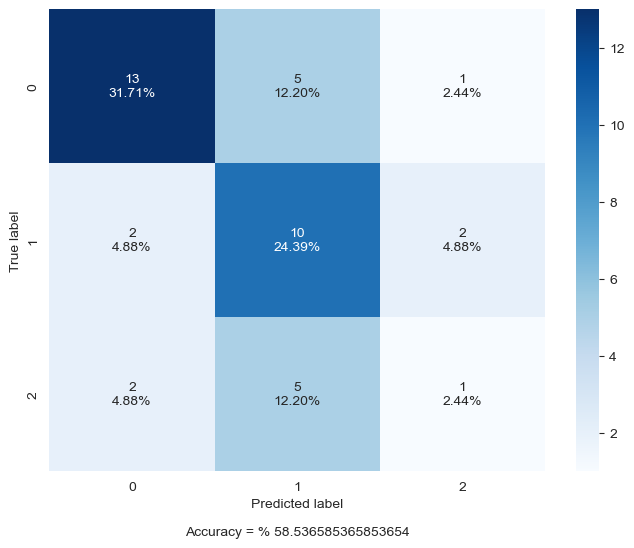

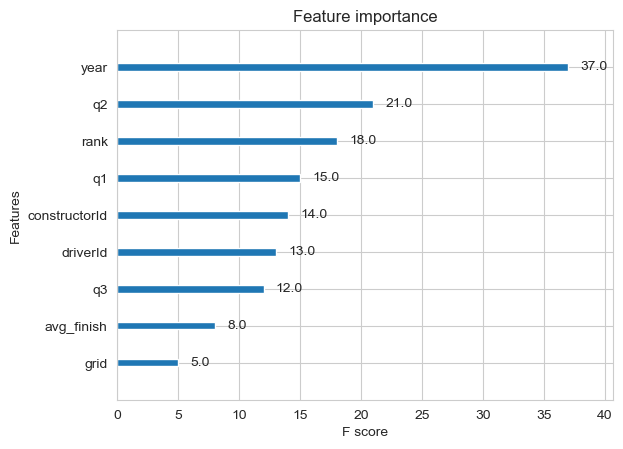

In [13]:
search_params = {
        'min_child_weight': [0 , 1, 5, 10],
        'gamma': [0, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.8,],
        'max_depth': [3] } 

analyze_by_circuit(df, 1, search_params)

-------------------- Circuit de Barcelona-Catalunya --------------------
Grid Search found the following optimal parameters: 
colsample_bytree: 0.8
gamma: 1
max_depth: 3
min_child_weight: 1
subsample: 0.8



    ---------------- TEST SCORES ----------------    

               Accuracy (TRAIN) : 0.8450704225352113 
               ACCURACY (TEST) : 0.6792452830188679
----------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.63      0.89      0.74        27
         2.0       0.86      0.55      0.67        22

    accuracy                           0.68        53
   macro avg       0.50      0.48      0.47        53
weighted avg       0.68      0.68      0.65        53


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


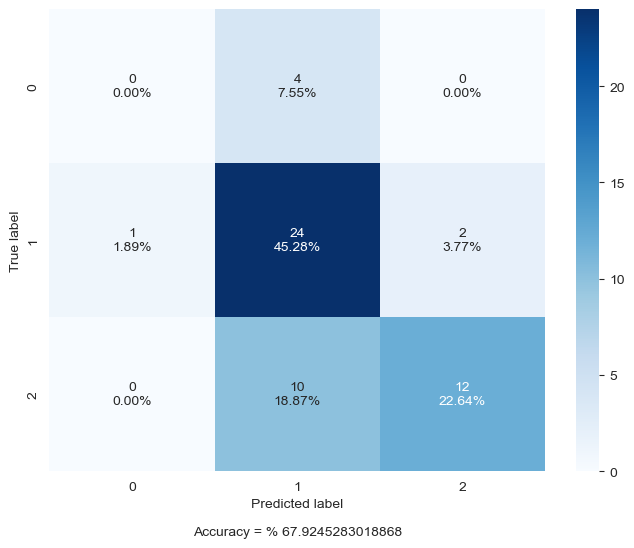

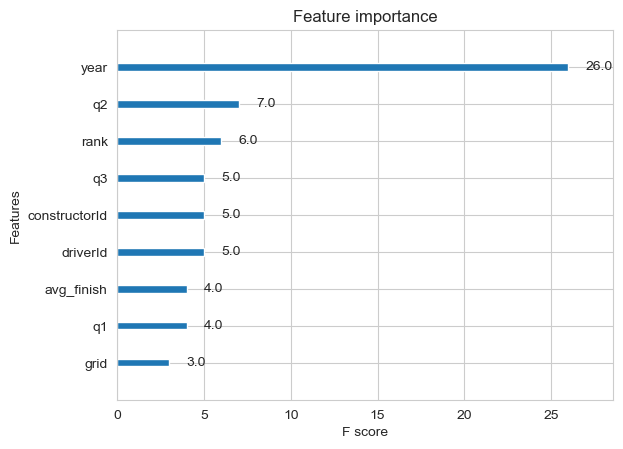

In [14]:
analyze_by_circuit(df, 4, search_params)

-------------------- Circuit de Monaco --------------------
Grid Search found the following optimal parameters: 
colsample_bytree: 0.8
gamma: 1
max_depth: 3
min_child_weight: 0
subsample: 1.0



    ---------------- TEST SCORES ----------------    

               Accuracy (TRAIN) : 0.8923076923076924 
               ACCURACY (TEST) : 0.6326530612244898
----------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.67      0.72      0.69        25
         1.0       0.63      0.60      0.62        20
         2.0       0.33      0.25      0.29         4

    accuracy                           0.63        49
   macro avg       0.54      0.52      0.53        49
weighted avg       0.63      0.63      0.63        49


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


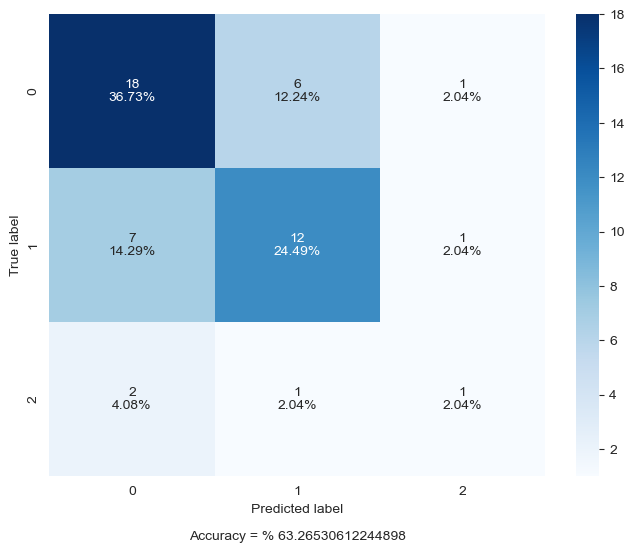

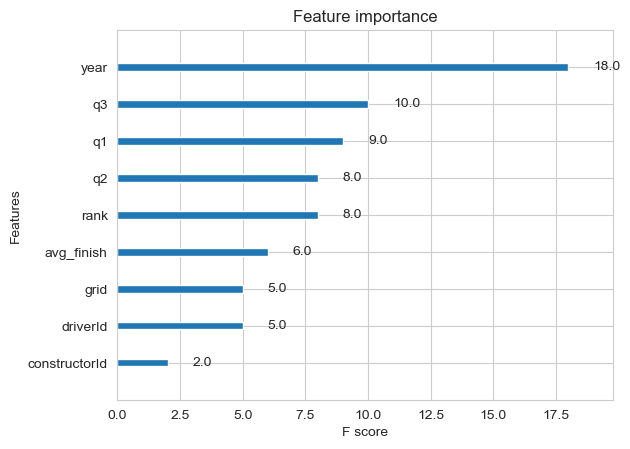

In [15]:
analyze_by_circuit(df, 6, search_params)

The performances of the models are around %60 - %70 because of the unpredictible nature of F1, such that crashed, weather conditions, unexpected tyre degradation problems, possible restarts to the race.
When we look at the feature importance plots, we can see that for the first two analysis the importance of the "year" is significantly higher than others, indicating that the pitstop strategies should be reconsidered every year, according to the changing regulations, pit-stop rules, and some changes for the track (number of corners, distance etc) 
The third analysis shows that the importance of the overall speed of the car ( lap times of qualification sessions ) is becoming more important

### ETHICAL ANALYSIS & LIMITATIONS

We used publicly available Formula 1 data for our analysis, so there's no need to worry about privacy or safety. We made sure to use the data responsibly to find useful insights. This analysis is solely for observational purposes and does not intend to cause harm or disparage any individuals or entities associated with Formula 1. It is conducted with the aim of providing insights based on available data while maintaining a respectful and impartial approach.

However, it's important to note that our analysis has some limitations. The dataset lacks detailed information on certain things that could really impact race results, like minute-by-minute weather conditions, the type of tires used, whether engines were new, tire performance, laps with safety car interventions, and pit stops during safety car periods. Without this info, our analysis might miss important factors affecting race strategies and outcomes. It's important to mention these limitations so that everyone understands our findings better and knows we're being open about our research.
